### Compare Heat Pump Rated Power from different methods
1. Regressions of MCA
   - MCA = C0 + C1*x, where x = rated_capacity (this is what we used in the project) (denoted: w__regression)
   - MCA = C0 + C1*x + C2*y, where x = rated_capacity, y = SEER (denoted: w__reg_cap_seer)
   - MCA = C0 + C1*x, where x = rated_capacity/SEER (denoted: w__reg_seer_adj_cap)
2. Rated power = rated capacity / rated COP
   - EERs for cooling are rated at (A) 95 deg(F) & (B) 82 deg(F), Btu cooling / Wh energy
   - COPs for heating are rated at () 47 & () 17 deg(F), Btu heating / Btu energy (%)
3. Rated power = rated capacity / seasonal COP
   - SEER: Btu cooling / Wh energy, over entire season
   - HSPF: Btu heating / Wh energy, over entire season

In [1]:
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

In [ ]:
# 1 Wh = 3.41214 Btu, to convert from (S)EER, HSPF to % eff (COP), divide by 3.41214

def apply_efficiency(rated_cap_kbtu_h: float, eff_btu_per_w:float | None=None, eff_pct=None) -> float:
    """ 
    If efficiency is EER, SEER, or HSPF, use eff_btu_per_w as the input 
    if COP, use eff_pct
    """
    if (eff_btu_per_w is None and eff_pct is None) or (eff_btu_per_w is not None and eff_pct is not None):
        raise ValueError("Either eff_btu_per_w or eff_pct must be specified")
    if eff_pct is not None:
        KBTU_H_TO_W = 293.07103866
        return rated_cap_kbtu_h / eff_pct * KBTU_H_TO_W # VA
    if eff_btu_per_w is not None:
        kW_TO_W = 1000
        return rated_cap_kbtu_h / eff_btu_per_w * kW_TO_W # VA

def apply_cop_using_hspf(rated_cap_kbtu_h: float, hspf: float) -> float:
    # https://github.com/NREL/OpenStudio-HPXML/blob/master/HPXMLtoOpenStudio/resources/hvac.rb#L1760
    cop = 0.0353 * hspf**2 + 0.0331 * hspf + 0.9447
    return apply_efficiency(rated_cap_kbtu_h, eff_pct=cop)

def apply_cop_using_seer(rated_cap_kbtu_h: float, seer: float, two_stage=False) -> float:
    # net: include blower
    # gross: ODU only
    if two_stage:
        # https://github.com/NREL/OpenStudio-HPXML/blob/master/HPXMLtoOpenStudio/resources/hvac.rb#L1707
        cop = 0.2773 * seer - 0.0018 # gross COP, 95F?, two-stage
    else:
        # https://github.com/NREL/OpenStudio-HPXML/blob/master/HPXMLtoOpenStudio/resources/hvac.rb#L1695
        cop = 0.2692 * seer + 0.2706 # gross COP, 95F, single-stage

    return apply_efficiency(rated_cap_kbtu_h, eff_pct=cop)

def apply_regression(rated_cap_kbtu_h):
    """ Regression of MCA and rated capacity for direct expansion systems
    Based on n=174, including three >5-ton systems, adjusted R2 = 0.855 (addition of SEER changes R2 by 0.01)
    Note: this also applies to central and room AC
    """
    mca = 0.626*rated_cap_kbtu_h + 1.634  # A
    vs = 230  # V
    return vs*mca  # VA

def apply_regression_with_seer(rated_cap_kbtu_h, seer):
    """ Regression of MCA, seer, and rated capacity for direct expansion systems
    This eq implies that SEER serves to affect the intercept of the reg, higher SEER -> higher MCA...
    Note: this also applies to central and room AC
    """
    mca = -1.44 + 0.287*seer + 0.562*rated_cap_kbtu_h  # A (n=102, adj. R2=0.81)
    # mca = 0 + 0.215*seer + 0.538*rated_cap_kbtu_h  # A (n=164, R2=0.82)
    vs = 230  # V
    return vs*mca  # VA

def apply_regression_with_seer_adj_cap(rated_cap_kbtu_h, seer):
    """ Regression of MCA and rated capacity normalized by seer for direct expansion systems
    Based on n=174, R2 = 0.648
    This eq 
    Note: this also applies to central and room AC
    """
    x = rated_cap_kbtu_h/seer  # kW, input power proxy
    mca = 9.137*x + 4.0943 # A
    vs = 230  # V
    return vs*mca  # VA

def convert_to_seer(eer: float|None=None, cop: float|None=None):
    if (eer is None and cop is None) or (eer is not None and cop is not None):
        raise ValueError("Either eer or cop must be specified")
    if eer is not None:
        BTU_H_TO_W = 0.29307103866
        cop = eer*BTU_H_TO_W
    seer = (cop - 0.2706) / 0.2692
    return seer
    

In [3]:
def calculate_heat_pump_rated_power(df, hp_eff):
    option_cols = [x for x in df.columns if "option" in x and "name" in x]
    df_opt = df[option_cols].astype(str).agg("".join, axis=1)
    cond1 = df_opt.str.contains("ASHP")
    cond2 = df_opt.str.contains("MSHP")
    bldg = df.loc[(cond1 | cond2), "building_id"]
    cap = df.loc[(cond1 | cond2), "upgrade_costs.size_heating_system_primary_k_btu_h"].rename("cap_kbtu_h")
    
    hp_type = pd.Series(index=cap.index).rename("hp_type")
    hp_type[cond1] = "ASHP"
    hp_type[cond2] = "MSHP"

    # 1.1. based on regression
    w_reg = cap.map(apply_regression).rename("w__regression")

    # 1.2. based on regression with cap + SEER
    w_reg_seer = pd.Series(index=cap.index).rename("w__reg_cap_seer")
    w_reg_seer[cond1] = cap.loc[cond1].map(
        lambda x: apply_regression_with_seer(x, hp_eff["ashp"]["seer"])
    )
    w_reg_seer[cond2] = cap.loc[cond2].map(
        lambda x: apply_regression_with_seer(x, hp_eff["mshp"]["seer"])
    )
    
    # 1.3 based on regression with SEER-adjusted cap (i.e., cap/SEER)
    w_reg_seer_adj = pd.Series(index=cap.index).rename("w__reg_seer_adj_cap")
    w_reg_seer_adj[cond1] = cap.loc[cond1].map(
        lambda x: apply_regression_with_seer_adj_cap(x, hp_eff["ashp"]["seer"])
    )
    w_reg_seer_adj[cond2] = cap.loc[cond2].map(
        lambda x: apply_regression_with_seer_adj_cap(x, hp_eff["mshp"]["seer"])
    )
    
    # 2.1 based on heating seasonal HSPF
    w_sheat = pd.Series(index=cap.index).rename("w__heating_hspf")
    w_sheat[cond1] = cap.loc[cond1].map(
        lambda x: apply_efficiency(x, eff_btu_per_w=hp_eff["ashp"]["hspf"])
    )
    w_sheat[cond2] = cap.loc[cond2].map(
        lambda x: apply_efficiency(x, eff_btu_per_w=hp_eff["mshp"]["hspf"])
    )
    
    # 2.2 based on cooling seasonal SEER
    w_scool = pd.Series(index=cap.index).rename("w__cooling_seer")
    w_scool[cond1] = cap.loc[cond1].map(
        lambda x: apply_efficiency(x, eff_btu_per_w=hp_eff["ashp"]["seer"])
    )
    w_scool[cond2] = cap.loc[cond2].map(
        lambda x: apply_efficiency(x, eff_btu_per_w=hp_eff["mshp"]["seer"])
    )
    
    # 3.1 based on heating rated COP
    w_heat = pd.Series(index=cap.index).rename("w__heating_cop")
    w_heat[cond1] = cap.loc[cond1].map(
        lambda x: apply_cop_using_hspf(x, hp_eff["ashp"]["hspf"])
    )
    w_heat[cond2] = cap.loc[cond2].map(
        lambda x: apply_cop_using_hspf(x, hp_eff["mshp"]["hspf"])
    )
    
    # 3.2 based on cooling rated SEER
    w_cool = pd.Series(index=cap.index).rename("w__cooling_cop")
    w_cool[cond1] = cap.loc[cond1].map(
        lambda x: apply_cop_using_seer(x, hp_eff["ashp"]["seer"])
    )
    w_cool[cond2] = cap.loc[cond2].map(
        lambda x: apply_cop_using_seer(x, hp_eff["mshp"]["seer"])
    )

    return pd.concat([
        bldg, hp_type, cap, 
        w_reg, w_reg_seer, w_reg_seer_adj, 
        w_sheat, w_scool, 
        w_heat, w_cool
    ], axis=1)

In [4]:
## Load
file_dir = Path("/Volumes/Lixi_Liu/panels_results_550k")
# low_eff_hp 
dfl = pd.read_parquet(file_dir / "results_up02.parquet")
# high_eff_hp
dfh = pd.read_parquet(file_dir / "results_up04.parquet")

outdir = Path("/Users/lliu2/Desktop/panels/HP power rating")

In [5]:
## Defne HP efficiency lookup
# https://github.com/NREL/resstock/blob/panels_final/project_national/panel_upgrades_19_upgrades.yml
low_eff_hp = {
    "ashp": {"seer": 15.05, "hspf": 8.82},  # ASHP, SEER 15.05, 8.82 HSPF, HERS, Supplemental Backup Sizing
    "mshp": {"seer": 14.5, "hspf": 8.33},  # MSHP, SEER 14.5, 8.33 HSPF, HERS, Supplemental Backup Sizing
}
high_eff_hp = {
    "ashp": {"seer": 20, "hspf": 11},  # ASHP, SEER 20, 11 HSPF, CCHP, Max Load, Supplemental Backup Sizing
    "mshp": {"seer": 20, "hspf": 11},  # MSHP, SEER 20, 11 HSPF, CCHP, Max Load, Supplemental Backup Sizing
}


In [6]:
### check calculations
hspf = 11
cop = 0.0353 * hspf**2 + 0.0331 * hspf + 0.9447

output = dfh.loc[dfh["building_id"]==2, "upgrade_costs.size_heating_system_primary_k_btu_h"][0]
input = output / cop # = power in kbtu/h
power = input * 293.07103866 # power in W

msg = f"""
- rated capacity: {output} kbtu/h
- HSPF: {hspf} >> COP: {cop}
- rated power: {input} ktbu/h = {power} W
"""
print("Based on hand calc")
print(msg)

print("Based on func")
print(apply_cop_using_hspf(output, hspf))

Based on hand calc

- rated capacity: 41.37 kbtu/h
- HSPF: 11 >> COP: 5.5801
- rated power: 7.41384563000663 ktbu/h = 2172.7834392509453 W

Based on func
2172.7834392509453


### Calculate rated power

In [7]:
## low-eff HP
lres = calculate_heat_pump_rated_power(dfl, low_eff_hp)
lres.to_csv(outdir / "low_eff_hp_power_ratings.csv", index=False)
lres

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hp_type = pd.Series(index=cap.index).rename("hp_type")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  w_reg_seer = pd.Series(index=cap.index).rename("w__reg_cap_seer")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  w_reg_seer_adj = pd.Series(index=cap.index).rename("w__reg_seer_adj_cap")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/417

,building_id,hp_type,cap_kbtu_h,w__regression,w__reg_cap_seer,w__reg_seer_adj_cap,w__heating_hspf,w__cooling_seer,w__heating_cop,w__cooling_cop
0,2,ASHP,37.72,5806.7456,5537.9377,6208.729346,4276.643991,2506.312292,2775.655082,2557.724691
1,3,MSHP,16.22,2711.1756,2722.5422,3292.481566,1947.178872,1118.620690,1295.314722,1138.862541
2,4,ASHP,39.68,6088.9464,5791.2873,6482.414369,4498.866213,2636.544850,2919.883183,2690.628731
3,5,ASHP,58.59,8811.6082,8235.5939,9122.916302,6642.857143,3893.023256,4311.390013,3972.881486
4,6,MSHP,52.33,7910.2934,7390.1208,8525.966124,6282.112845,3608.965517,4179.027089,3674.271072
...,...,...,...,...,...,...,...,...,...,...
424732,549995,ASHP,116.81,17194.1238,15761.1111,17252.478575,13243.764172,7761.461794,8595.553292,7920.673944
424733,549996,ASHP,29.36,4603.0728,4457.3241,5041.378940,3328.798186,1950.830565,2160.478081,1990.848275
424734,549997,ASHP,41.08,6290.5184,5972.2513,6677.903671,4657.596372,2729.568106,3022.903255,2785.560188
424735,549998,ASHP,8.07,1537.7386,1705.3787,2068.545193,914.965986,536.212625,593.837129,547.212043


In [8]:
## high-eff HP
hres = calculate_heat_pump_rated_power(dfh, high_eff_hp)
hres.to_csv(outdir / "high_eff_hp_power_ratings.csv", index=False)
hres

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hp_type = pd.Series(index=cap.index).rename("hp_type")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  w_reg_seer = pd.Series(index=cap.index).rename("w__reg_cap_seer")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/4170904843.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  w_reg_seer_adj = pd.Series(index=cap.index).rename("w__reg_seer_adj_cap")
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/417

,building_id,hp_type,cap_kbtu_h,w__regression,w__reg_cap_seer,w__reg_seer_adj_cap,w__heating_hspf,w__cooling_seer,w__heating_cop,w__cooling_cop
0,2,ASHP,41.37,6332.2726,6336.4862,5288.662435,3760.909091,2068.5,2172.783439,2144.156770
1,3,MSHP,17.85,2945.8630,3296.2910,2817.286675,1622.727273,892.5,937.495393,925.143784
2,4,ASHP,42.88,6549.6824,6531.6688,5447.326440,3898.181818,2144.0,2252.089772,2222.418233
3,5,ASHP,64.89,9718.6822,9376.6814,7760.038195,5899.090909,3244.5,3408.071486,3363.169755
4,6,MSHP,54.99,8293.2802,8097.0074,6719.790745,4999.090909,2749.5,2888.116058,2850.064800
...,...,...,...,...,...,...,...,...,...,...
424732,549995,ASHP,129.66,19044.2668,17748.8516,14565.778330,11787.272727,6483.0,6809.840482,6720.120057
424733,549996,ASHP,29.83,4670.7434,4844.8258,4076.091165,2711.818182,1491.5,1566.693981,1546.052609
424734,549997,ASHP,45.15,6876.5170,6825.0890,5685.847825,4104.545455,2257.5,2371.311875,2340.069571
424735,549998,ASHP,8.13,1546.3774,2039.8838,1795.952815,739.090909,406.5,426.993700,421.368009


### Visualize

In [9]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)
    plt.tight_layout()

def plot_scatter_comparison(df: pd.DataFrame, x_col: str, y_col: str, color_by: str, title: str):
    # Usage: plot_scatter_comparison(lres, "w__regression", "w__reg_seer_adj_cap", "hp_type", "low-eff HP")
    grid = sns.pairplot(x_vars=[x_col], y_vars=[y_col], data=df, hue=color_by, height=5)
    grid.fig.suptitle(title)
    grid.map_offdiag(plot_unity)

def plot_all_methods(df: pd.DataFrame, title: str, hp_type: str="ASHP"):
    w_cols = [x for x in df.columns if x.startswith("w__")]
    res = df.loc[df["hp_type"]==hp_type]
    res = pd.melt(res, id_vars=["cap_kbtu_h"], value_vars=w_cols, var_name="method", value_name="rated_power_w")
    
    grid = sns.pairplot(x_vars=['cap_kbtu_h'], y_vars=['rated_power_w'], data=res, hue="method", height=5)
    grid.fig.suptitle(title)

def plot_ratios(df: pd.DataFrame, title: str):
    w_cols = [x for x in lres.columns if x.startswith("w__") and x != "w__regression"]
    fig, axs = plt.subplots(len(w_cols),1, sharex=True)
    for i, x in enumerate(w_cols):
        (lres[x] / lres["w__regression"]).hist(ax=axs[i])
        axs[i].set_title(f"{x} as % w_regression")
    fig.suptitle("low-eff HP")

#### Low-eff HP

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


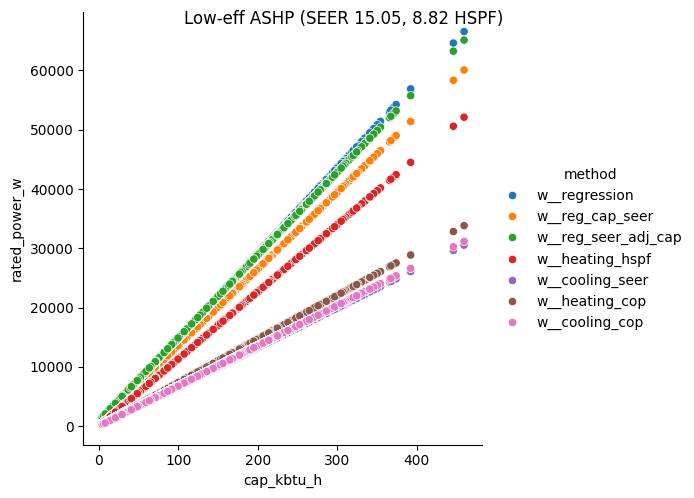

In [10]:
plot_all_methods(lres, "Low-eff ASHP (SEER 15.05, 8.82 HSPF)", hp_type="ASHP")

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


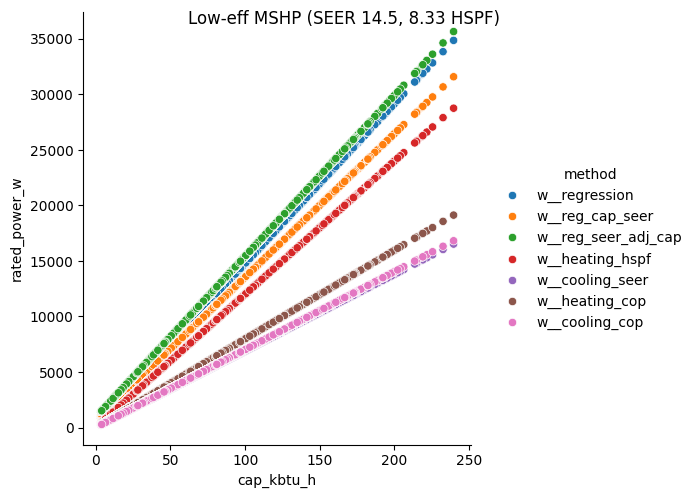

In [11]:
plot_all_methods(lres, "Low-eff MSHP (SEER 14.5, 8.33 HSPF)", hp_type="MSHP")

### High-eff HP

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


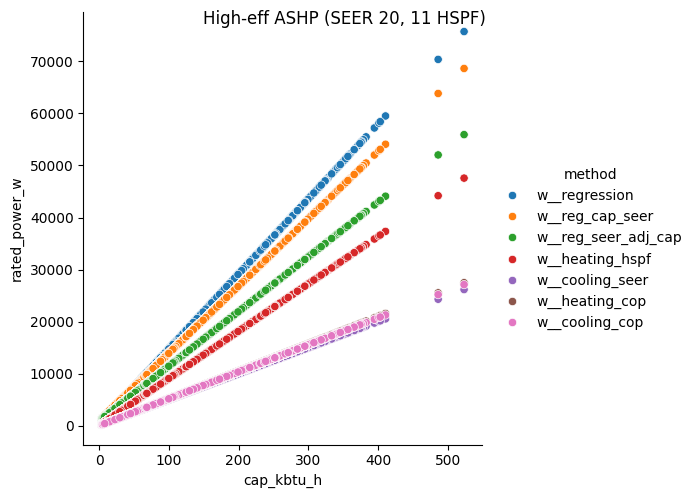

In [12]:
plot_all_methods(hres, "High-eff ASHP (SEER 20, 11 HSPF)", hp_type="ASHP")

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


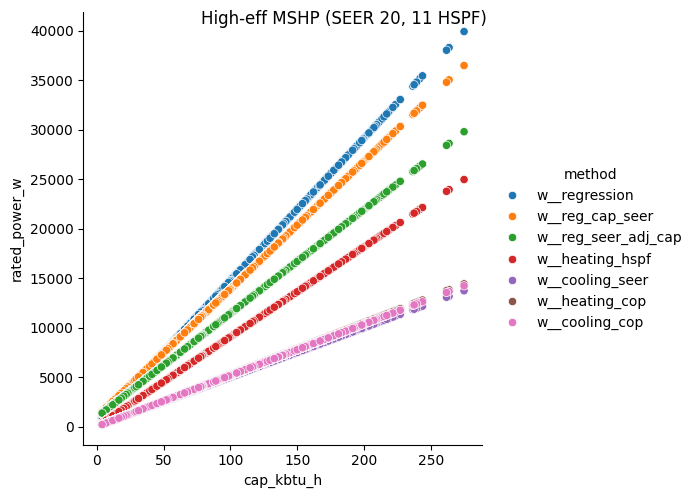

In [13]:
plot_all_methods(hres, "High-eff MSHP (SEER 20, 11 HSPF)", hp_type="MSHP")

#### Compare results as x vs. y

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/712857313.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


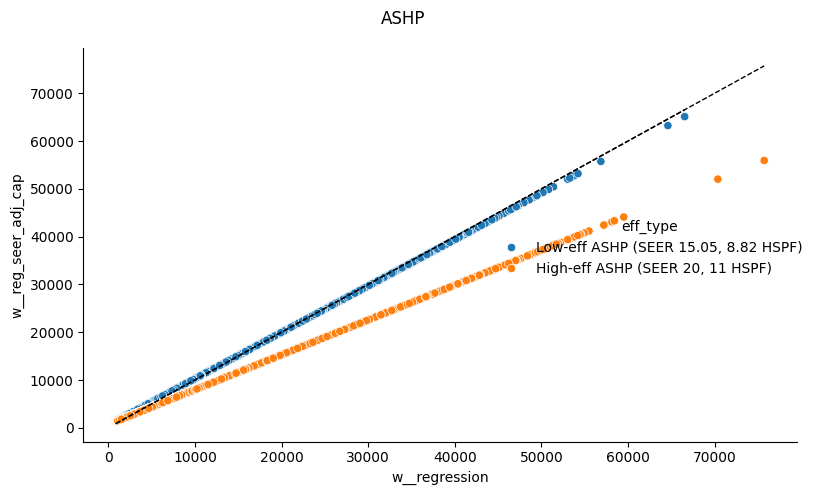

In [14]:
hp_type = "ASHP"
x_col = "w__regression"
y_col = "w__reg_seer_adj_cap"

res = pd.concat([
    lres.loc[lres["hp_type"]==hp_type, [x_col, y_col]].reset_index(drop=True).assign(eff_type="Low-eff ASHP (SEER 15.05, 8.82 HSPF)"),
    hres.loc[hres["hp_type"]==hp_type, [x_col, y_col]].reset_index(drop=True).assign(eff_type="High-eff ASHP (SEER 20, 11 HSPF)")
], axis=0)

plot_scatter_comparison(res, x_col, y_col, "eff_type", hp_type)

/Users/lliu2/micromamba/envs/panels/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_31327/712857313.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


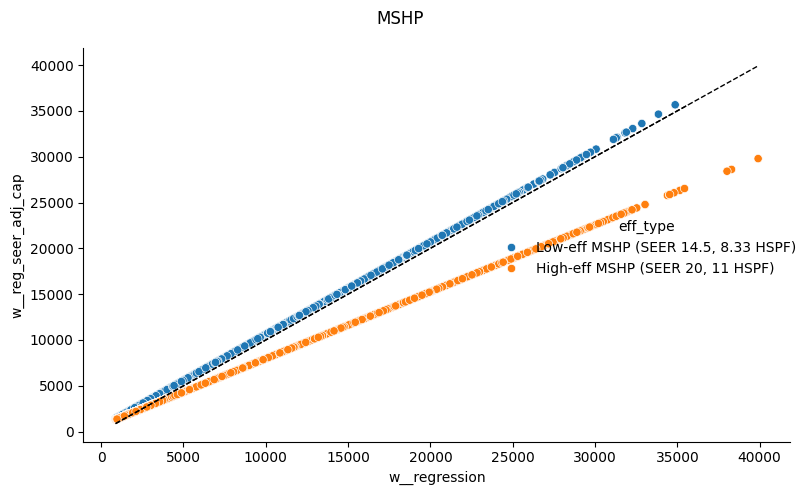

In [15]:
hp_type = "MSHP"
x_col = "w__regression"
y_col = "w__reg_seer_adj_cap"

res = pd.concat([
    lres.loc[lres["hp_type"]==hp_type, [x_col, y_col]].reset_index(drop=True).assign(eff_type="Low-eff MSHP (SEER 14.5, 8.33 HSPF)"),
    hres.loc[hres["hp_type"]==hp_type, [x_col, y_col]].reset_index(drop=True).assign(eff_type="High-eff MSHP (SEER 20, 11 HSPF)")
], axis=0)

plot_scatter_comparison(res, x_col, y_col, "eff_type", hp_type)

#### Ratio between other methods and w__regression
Combines MSHP and ASHP

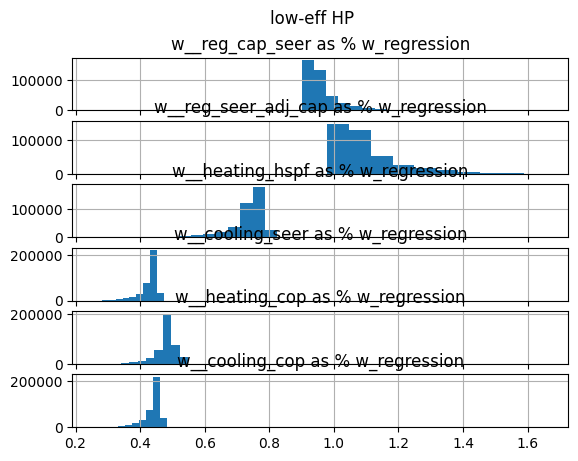

In [16]:
plot_ratios(lres, "Low-eff HP")

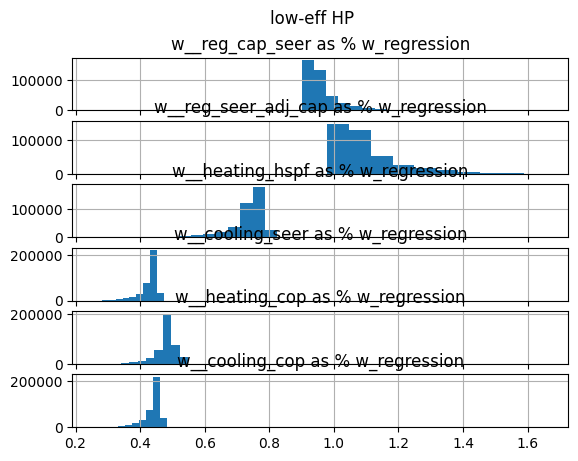

In [18]:
plot_ratios(hres, "High-eff HP")